In [1]:
import numpy as np
from numpy import sqrt, pi
import math
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

import cadquery as cq
from cadquery import exporters
from jupyter_cadquery.cadquery import (PartGroup, Part, Edges, Faces, Vertices, show)
from jupyter_cadquery import set_defaults, set_sidecar
set_defaults(theme="dark")
set_sidecar("CadQuery", init=True)

from tqdm import tqdm
from time import perf_counter

import os
from pathlib import Path
cwd=os.getcwd()
home = str(Path(os.path.abspath(cwd)).parents[1])

Overwriting auto display for cadquery Workplane and Shape


In [2]:
# FUNCTIONS

In [3]:
def hexGen(xVect,yVect):
    for i in range(len(yVect)):
        if i==0:
            yNew=np.ones(len(xVect))*yVect[i]
            xNew=xVect
        else:
            yNew=np.concatenate((yNew, np.ones(len(xVect))*yVect[i]), axis=None)
            xNew=np.concatenate((xNew, xVect), axis=None)
    return xNew, yNew

In [4]:
def hedronGen(a):
    
    #a=1 #side length
    degree=90-math.atan(1/sqrt(2))*180/math.pi

    quadside=2*a/sqrt(3)
    L=sqrt(2/3)*a
    pts = [
        (0,0),
        (L,-L),
        (0,-2*L),
        (-L,-L)
    ]

    workplane=cq.Workplane('XY').transformed(offset=cq.Vector(0, 0, -a),rotate=cq.Vector(-degree, 0, 0))
    base=workplane.polyline(pts).close().extrude(quadside)

    dx=quadside #in fact dy
    dz=quadside #in fact dx
    dy=a/sqrt(3) #in fact dz
    wedge1=workplane.transformed(offset=cq.Vector(0,-L,dy/2+quadside),rotate=cq.Vector(90,-45,0)).wedge(dx, dy, dz, dx/2, dz/2, dx/2, dz/2, pnt=cq.Vector(0.0, 0.0, 0.0), dir=cq.Vector(0.0, 0.0, 1.0))
    wedge2=workplane.workplane(invert=True).transformed(offset=cq.Vector(0,L,dy/2),rotate=cq.Vector(90,-45,0)).wedge(dx, dy, dz, dx/2, dz/2, dx/2, dz/2, pnt=cq.Vector(0.0, 0.0, 0.0), dir=cq.Vector(0.0, 0.0, 1.0))
    wedge3=workplane.transformed(rotate=cq.Vector(0,0,-45)).transformed(offset=cq.Vector(quadside/2,dy/2,quadside/2),rotate=cq.Vector(0,90,0)).wedge(dx, dy, dz, dx/2, dz/2, dx/2, dz/2, pnt=cq.Vector(0.0, 0.0, 0.0), dir=cq.Vector(0.0, 0.0, 1.0))
    wedge4=workplane.transformed(rotate=cq.Vector(0,0,-45)).transformed(offset=cq.Vector(quadside/2,-quadside-dy/2,quadside/2),rotate=cq.Vector(0,90,0)).workplane(invert=True).wedge(dx, dy, dz, dx/2, dz/2, dx/2, dz/2, pnt=cq.Vector(0.0, 0.0, 0.0), dir=cq.Vector(0.0, 0.0, 1.0))
    wedge5=workplane.transformed(rotate=cq.Vector(0,0,45)).transformed(offset=cq.Vector(-quadside/2,dy/2,quadside/2),rotate=cq.Vector(0,90,0)).wedge(dx, dy, dz, dx/2, dz/2, dx/2, dz/2, pnt=cq.Vector(0.0, 0.0, 0.0), dir=cq.Vector(0.0, 0.0, 1.0))
    wedge6=workplane.transformed(rotate=cq.Vector(0,0,45)).transformed(offset=cq.Vector(-quadside/2,dy/2-1.5*quadside,quadside/2),rotate=cq.Vector(0,90,0)).workplane(invert=True).wedge(dx, dy, dz, dx/2, dz/2, dx/2, dz/2, pnt=cq.Vector(0.0, 0.0, 0.0), dir=cq.Vector(0.0, 0.0, 1.0))

    rhombicDodecahedron=(base.union(wedge1,glue=True,clean=True).union(wedge2,glue=True,clean=True).union(wedge3,glue=True,clean=True).union(wedge4,glue=True,clean=True).union(wedge5,glue=True,clean=True).union(wedge6,glue=True,clean=True))

    #rhombicDodecahedron=rhombicDodecahedron.translate(cq.Vector(X,Y,Z))
    
    return rhombicDodecahedron

In [5]:
def abcGen(L,T,a1,X1,X2,Y1,Y2,Z1,Z2,A1,A2):
    sD=cq.Workplane('XY').transformed(offset=cq.Vector(0, 0, Z1[0])).rect(L,T,centered=True,forConstruction=False).extrude(4*a1/3)
    # the box is ready
    hedra=[]
    
    for i in tqdm(range(X1.size)):
        hedra.append(hedronGen(A1[i]).translate(cq.Vector(X1[i],Y1[i],Z1[i])))
    
    for i in tqdm(range(X2.size)):
        hedra.append(hedronGen(A2[i]).translate(cq.Vector(X2[i],Y2[i],Z2[i])))

    for i in tqdm(range(len(hedra))):
        sD=sD.cut(hedra[i],clean=True)

    return sD

In [55]:
def densify(R,VF,d):
    volFrac=np.ones(len(R))
    for i in range(len(R)):
        if R[i]<=(d/2):
            volFrac[i]=1
        else:
            volFrac[i]=np.exp(-0.4*(R[i]-d/2)+np.log(1-VF))+VF
    return volFrac

In [56]:
def calcSideLen(volFrac,a1):
    A=np.zeros(len(volFrac))
    for i in range(len(volFrac)):
        A[i]=a1*((1-volFrac[i])**(1./3.))
    return A

In [57]:
def calcDist(X,Y):
    R=np.zeros(len(X))
    for i in range(len(R)):
        R[i]=sqrt(X[i]*X[i]+Y[i]*Y[i])
    return R

In [89]:
def remPts(X,Y,Z,R,vF,A,d):
    rem_ind=[]
    for i in range(len(R)):
        if (R[i]-math.sin(gamma)*A[i])<(d/2) or A[i]<=0.05:
            rem_ind.append(i)
    rem_ind.reverse()
    for i in range(len(rem_ind)):
        X=np.delete(X,rem_ind[i])
        Y=np.delete(Y,rem_ind[i])
        Z=np.delete(Z,rem_ind[i])
        R=np.delete(R,rem_ind[i])
        vF=np.delete(vF,rem_ind[i])
        A=np.delete(A,rem_ind[i])
    return X, Y, Z, R, vF, A

In [ ]:
def speak(text):
    from IPython.display import Javascript as js, clear_output
    # Escape single quotes
    text = text.replace("'", r"\'")
    display(js(f'''
    if(window.speechSynthesis) {{
        var synth = window.speechSynthesis;
        synth.speak(new window.SpeechSynthesisUtterance('{text}'));
    }}
    '''))
    # Clear the JS so that the notebook doesn't speak again when reopened/refreshed
    clear_output(False)

In [90]:
# DATA

VF=0.14      #Volume Fraction
a0=0.625     #[mm] Average Cell Size / 2
L=20         #[mm] Length (x) of Sample
T=20         #[mm] Width (y) of Sample
U=20         #[mm] Height (z) of Sample
holeDiam=2.7 #[mm] Diameter of Drilled Hole
dImpl=3.8    #[mm] Greatest Outer Diameter of the Implant

a1=a0/((1-VF)**(1./3.))
gamma=math.pi/2-math.atan(1/sqrt(8))
hexL0=math.sin(gamma)*a0
hexL1=math.sin(gamma)*a1
d=sqrt(3)*(hexL1-hexL0) #initial wall thickness
D=sqrt(3)*hexL1 #Distance between Hex Centres on the x axis
H=(3/2)*hexL1 #Distance between Hex Centres on the y axis


Nxa=math.ceil(L/D+1)
if Nxa%2 != 1: #if not odd
    Nxb=Nxa+2 #then with +2 it is good for b-row
    Nxa=Nxa+1 #and has to be incremented for a-row
else: #if odd
    Nxb=Nxa+1 #then a is good, b must be incremented
    
Ny=math.ceil(T/H+1)
if Ny%2 != 1: #if not odd
    Ny=Ny+1 #then increment it
if ((Ny-1)/2)%2 != 1: #if not odd
    Nya=int((Ny+1)/2)
    Nyb=int(Nya+1)
else:
    Nyb=int((Ny+1)/2)
    Nya=int(Nyb+1)
Ny=Nya+Nyb
print("d = ", d,"\nD = ", D, "\nH = ", H, "\nNx:\n\tNxa = ", Nxa, "\n\tNxb = ", Nxb, "\nNy = ", Ny,"\n\tNya = ", Nya, "\n\tNyb = ", Nyb)

d =  0.052622690240005994 
D =  1.0732434163996636 
H =  0.9294560630465091 
Nx:
	Nxa =  21 
	Nxb =  22 
Ny =  25 
	Nya =  13 
	Nyb =  12


In [91]:
# LAYER 'A'

aX=np.linspace(-((Nxa-1)*D)/2, ((Nxa-1)*D)/2, num=Nxa)
bX=np.linspace(-((Nxa-1)*D)/2-(D/2), ((Nxa-1)*D)/2+(D/2), num=Nxb)

if Nya>Nyb:
    aY=np.linspace(-((Nya+Nyb-1)*H)/2, ((Nya+Nyb-1)*H)/2, num=Nya)
    bY=np.linspace(-((Nya+Nyb-1)*H)/2+H, ((Nya+Nyb-1)*H)/2-H, num=Nyb)
else:
    bY=np.linspace(-((Nya+Nyb-1)*H)/2, ((Nya+Nyb-1)*H)/2, num=Nyb)
    aY=np.linspace(-((Nya+Nyb-1)*H)/2+H, ((Nya+Nyb-1)*H)/2-H, num=Nya)

aX0=aX
aY0=aY
bX0=bX
bY0=bY
AaX, AaY = hexGen(aX0,aY0)
AbX, AbY = hexGen(bX0,bY0)

#%matplotlib widget
#plt.plot(AaX,AaY,'b.')
#plt.plot(AbX,AbY,'r.')
#plt.axis('equal')
#plt.show()

In [92]:
# LAYER 'B'

BaX=AaX
BaY=AaY-hexL1
BbX=AbX
BbY=AbY-hexL1

if Nya>Nyb: #'a' row is on the outside
    BbX=np.concatenate((BbX, bX0), axis=None)
    BbY=np.concatenate((BbY, np.ones(len(bX0))*(BaY[-1]+H)), axis=None)
        
else: #'b' row is on the outside
    BaX=np.concatenate((BaX, aX0), axis=None)
    BaY=np.concatenate((BaY, np.ones(len(aX0))*(BbY[-1]+H)), axis=None)

#%matplotlib widget
#plt.plot(AaX,AaY,'g.')
#plt.plot(AbX,AbY,'g.')
#plt.plot(BaX,BaY,'b.')
#plt.plot(BbX,BbY,'b.')
#plt.axis('equal')
#plt.show()

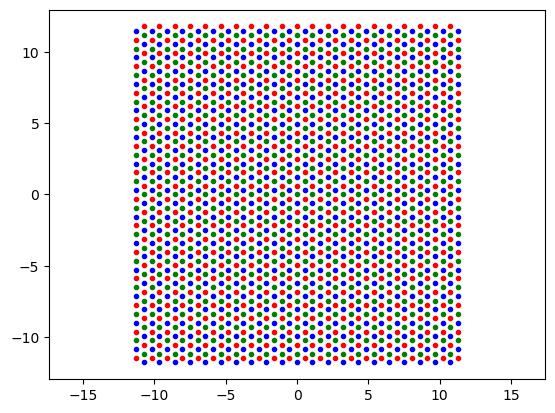

In [93]:
# LAYER 'C'

CaX=AaX
CaY=AaY+hexL1
CbX=AbX
CbY=AbY+hexL1

if Nya>Nyb: #'a' row is on the outside
    CbX=np.concatenate((CbX, bX0), axis=None)
    CbY=np.concatenate((CbY, np.ones(len(bX0))*(CaY[0]-H)), axis=None)
        
else: #'b' row is on the outside
    CaX=np.concatenate((CaX, aX0), axis=None)
    CaY=np.concatenate((CaY, np.ones(len(aX0))*(CbY[0]-H)), axis=None)

#%matplotlib widget
plt.plot(AaX,AaY,'g.')
plt.plot(AbX,AbY,'g.')
plt.plot(BaX,BaY,'b.')
plt.plot(BbX,BbY,'b.')
plt.plot(CaX,CaY,'r.')
plt.plot(CbX,CbY,'r.')
plt.axis('equal')
plt.show()

In [94]:
AX=np.concatenate((AaX, AbX), axis=None)
AY=np.concatenate((AaY, AbY), axis=None)
BX=np.concatenate((BaX, BbX), axis=None)
BY=np.concatenate((BaY, BbY), axis=None)
CX=np.concatenate((CaX, CbX), axis=None)
CY=np.concatenate((CaY, CbY), axis=None)

#%matplotlib widget
#plt.plot(AX,AY,'g.')
#plt.plot(BX,BY,'b.')
#plt.plot(CX,CY,'r.')
#plt.axis('equal')
#plt.show()

In [95]:
H_z=(4/3)*a1

AZ=np.zeros((len(AX)))
BZ=np.ones((len(BX)))*(4*a1/3)
CZ=np.ones((len(BX)))*(8*a1/3)

X=np.concatenate((AX,BX,CX), axis=None)
Y=np.concatenate((AY,BY,CY), axis=None)

R=calcDist(X,Y)

zeroIndex=np.where(R==0)[0][0]
X=np.delete(X,zeroIndex,None)
Y=np.delete(Y,zeroIndex,None)
R=np.delete(R,zeroIndex,None)

In [96]:
volFrac=densify(R,VF,dImpl)
A=calcSideLen(volFrac,a1)

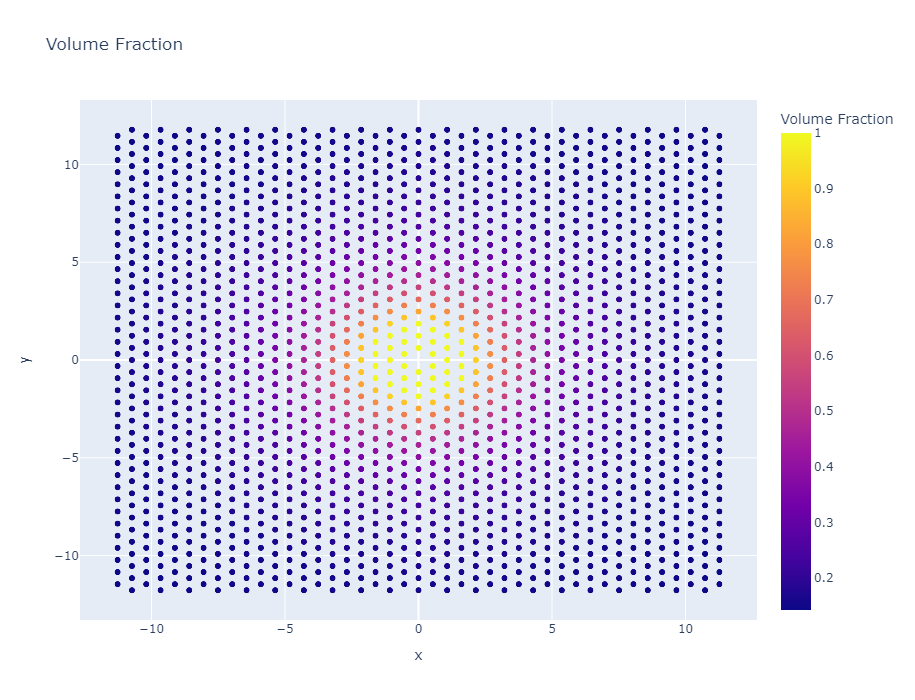

In [97]:
fig = px.scatter(x=X, y=Y, color=volFrac, labels={"color":"Volume Fraction"},
                 title="Volume Fraction",width=700,height=700,color_continuous_scale='Plasma')
fig.show()
fig.write_html(home+"\\img\\python\\generateStructure_final_fig_03.html")

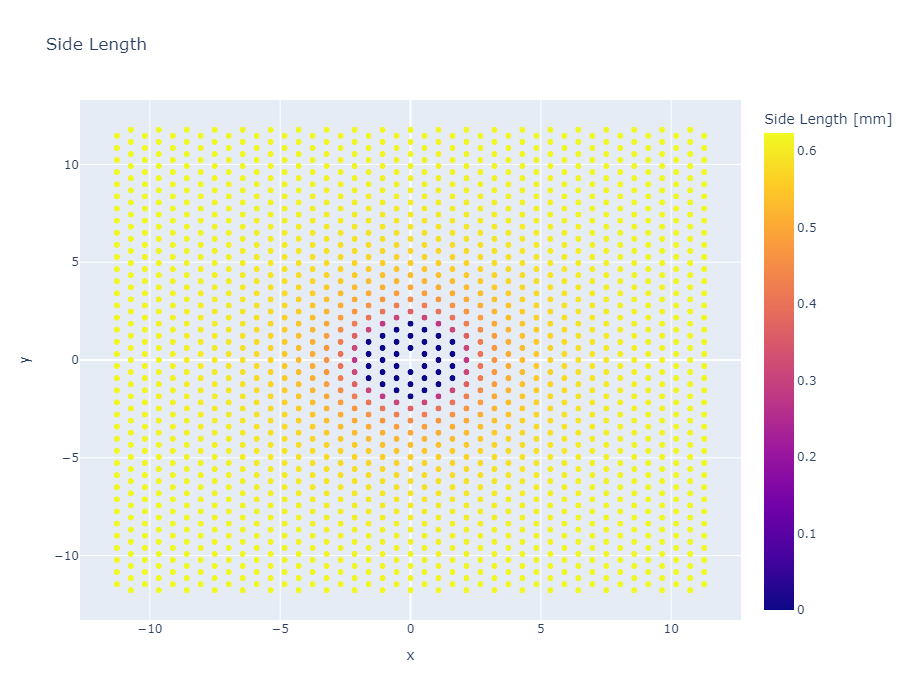

In [98]:
fig = px.scatter(x=X, y=Y, color=A, labels={"color":"Side Length [mm]"},
                 title="Side Length",width=700,height=700)
fig.show()
fig.write_html(home+"\\img\\python\\generateStructure_final_fig_04.html")

In [68]:
RA=calcDist(AX,AY)
RB=calcDist(BX,BY)
RC=calcDist(CX,CY)

zeroIndex=np.where(RA==0)[0][0]
AX=np.delete(AX,zeroIndex,None)
AY=np.delete(AY,zeroIndex,None)
AZ=np.delete(AZ,zeroIndex,None)
RA=np.delete(RA,zeroIndex,None)

volFracA=densify(RA,VF,dImpl)
volFracB=densify(RB,VF,dImpl)
volFracC=densify(RC,VF,dImpl)

AA=calcSideLen(volFracA,a1)
AB=calcSideLen(volFracB,a1)
AC=calcSideLen(volFracC,a1)

AX, AY, AZ, RA, volFracA, AA = remPts(AX, AY, AZ, RA, volFracA, AA, dImpl)
BX, BY, BZ, RB, volFracB, AB = remPts(BX, BY, BZ, RB, volFracB, AB, dImpl)
CX, CY, CZ, RC, volFracC, AC = remPts(CX, CY, CZ, RC, volFracC, AC, dImpl)

# AZ-> AZ1, AZ2
AZ1=AZ
AZ2=AZ+4*a1

In [69]:
print(len(AX),len(BX),len(CX))

518 547 547


In [70]:
sDA=abcGen(L,T,a1,AX,BX,AY,BY,AZ1,BZ,AA,AB)
show(sDA, grid=True)

100%|██████████| 1065/1065 [27:47<00:00,  1.57s/it]


Done, using side car 'Cadquery'


In [71]:
tic = perf_counter()
exporters.export(sDA, home+'\\out\\step\\BAM_A.step')
tac = perf_counter()
print("Elapsed time:", '%.5f' % (tac-tic) , "s")

Elapsed time: 17.84877 s


In [72]:
sDB=abcGen(L,T,a1,BX,CX,BY,CY,BZ,CZ,AB,AC)
show(sDB, grid=True)

100%|██████████| 1094/1094 [26:19<00:00,  1.44s/it]


Done, using side car 'Cadquery'


In [73]:
tic = perf_counter()
exporters.export(sDB, home+'\\out\\step\\BAM_B.step')
tac = perf_counter()
print("Elapsed time:", '%.5f' % (tac-tic) , "s")

Elapsed time: 9.15292 s


In [74]:
sDC=abcGen(L,T,a1,CX,AX,CY,AY,CZ,AZ2,AC,AA)

100%|██████████| 1065/1065 [23:06<00:00,  1.30s/it]


In [76]:
sDC=sdC
tic = perf_counter()
exporters.export(sDC, home+'\\out\\step\\BAM_C.step')
tac = perf_counter()
print("Elapsed time:", '%.5f' % (tac-tic) , "s")

Elapsed time: 10.83990 s


In [77]:
tic = perf_counter()
sDABC=sDA.union(sDB,glue=True).union(sDC,glue=True)
show(sDABC,grid=True)
tac = perf_counter()
print("Elapsed time:", '%.5f' % (tac-tic) , "s")

Done, using side car 'Cadquery'
Elapsed time: 95.89197 s


In [78]:
tic = perf_counter()
exporters.export(sDABC, home+'\\out\\step\\BAM_ABC.step')
tac = perf_counter()
print("Elapsed time:", '%.5f' % (tac-tic) , "s")

Elapsed time: 23.11881 s


In [79]:
Zsteps=math.ceil(math.log((U/(4*a1)), 2)+1)
Zmax=pow(2,Zsteps-1)*4*a1
diffZ=Zmax-U

In [80]:
# runtime 25-30m
for i in tqdm(range(Zsteps)):
    if i==0:
        sDGlued=sDABC
    else:
        sDGlued=sDGlued.union(sDGlued.translate(cq.Vector(0,0,pow(2,i-1)*4*a1)),glue=True)

show(sDGlued,grid=True)
speak("Glued all layers.")

100%|██████████| 4/4 [30:03<00:00, 450.96s/it]


Done, using side car 'Cadquery'


In [81]:
tic = perf_counter()
exporters.export(sDGlued, home+'\\out\\step\\BAM_sDGlued.step')
tac = perf_counter()
print("Elapsed time:", '%.5f' % (tac-tic) , "s")

Elapsed time: 183.28386 s


In [82]:
# runtime ~15m
tic = perf_counter()
slicer=cq.Workplane('XY').transformed(offset=cq.Vector(0,0,U)).rect(L+1,T+1,centered=True,forConstruction=False).extrude(diffZ+1)
sDFinal=sDGlued.cut(slicer,clean=True)
show(sDFinal)
tac = perf_counter()
print("Elapsed time:", '%.5f' % (tac-tic) , "s")
speak("Cut model to size.")

Done, using side car 'Cadquery'
Elapsed time: 1443.68069 s


In [83]:
# runtime ~11m
tic = perf_counter()
hole=cq.Workplane('XY').circle(holeDiam/2).extrude(U)
sDFinal=sDFinal.cut(hole,clean=True)
show(sDFinal)
tac = perf_counter()
print("Elapsed time:", '%.5f' % (tac-tic) , "s")
speak("Drilled the hole.")

Done, using side car 'Cadquery'
Elapsed time: 1454.06349 s


In [84]:
tic = perf_counter()
exporters.export(sDFinal, home+'\\out\\step\\BAM_sDFinal.step')
tac = perf_counter()
print("Elapsed time:", '%.5f' % (tac-tic) , "s")

Elapsed time: 95.49544 s


In [85]:
implant=cq.importers.importStep(home+'\\src\\implants\\screwline2_bekezdes.step')
implNeckHeight=1.5 #[mm]
implant=implant.translate(cq.Vector(0,0,U+implNeckHeight))
BAM = PartGroup(
    [
        Part(sDFinal, "sDFinal", "yellow", show_edges=False),
        Part(implant,"implant","red",show_edges=False),
    ],
    "Bone Analogous Material"
)
    
show(BAM,grid=True)

Done, using side car 'Cadquery'


In [86]:
# runtime ~11m
tic = perf_counter()
sDwImplCut=sDFinal.cut(implant,clean=True)
show(sDwImplCut)
tac = perf_counter()
print("Elapsed time:", '%.5f' % (tac-tic) , "s")
speak("Cut the implant into the model.")

Done, using side car 'Cadquery'
Elapsed time: 1432.56373 s


In [87]:
tic = perf_counter()
exporters.export(sDwImplCut, home+'\\out\\step\\BAM_sDwImplCut.step')
tac = perf_counter()
print("Elapsed time:", '%.5f' % (tac-tic) , "s")

Elapsed time: 132.43897 s


In [88]:
speak("All done.")